# 練習9-1 
## どのような機械学習手法を用いると良いか？

### 解答例
教師あり学習の分類

# 練習9-2
## どのようなアウトプットを得られるか？また、その分析結果からどのようにスッキリ銀行の課題を解決する事が出来るか？

### 解答例  
ｙ列を予測する分類モデルを作ることにより、その顧客が購入してくれるかどうかが事前に分かる。また、特徴量にこちらからのアプローチ法を入れる事により、「この顧客の場合、こういうアプローチをとったら購入してくれる」というような営業の最適化を行う事が出来る


# 練習9-3 
## ひとまず何でもいいのでモデルを作ってみましょう。ただし、データは訓練、検証、テストデータの3分割をする方法を利用すること

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
%matplotlib inline 

In [2]:
df = pd.read_csv('../datafiles/Bank.csv')
print(df.shape)
df.head()

(27128, 16)


,id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
0,1,39,blue-collar,married,secondary,no,1756.0,yes,no,cellular,3,apr,370.055237,1,0,1
1,2,51,entrepreneur,married,primary,no,1443.0,no,no,cellular,18,feb,233.998933,10,0,1
2,3,36,management,single,tertiary,no,436.0,no,no,cellular,13,apr,NaN,1,2,0
3,4,63,retired,married,secondary,no,474.0,no,no,cellular,25,jan,252.525808,1,0,0
4,5,31,management,single,tertiary,no,354.0,no,no,cellular,30,apr,NaN,1,2,0


In [7]:
# まず、ダミー変数化をしたいが、文字列の列が複数あるので抜き出す。
str_col_name=['job','default','marital','education','housing','loan','contact','month']

# for k,v in df.max().items:
#   print(type(v))
#   # if type(v)==: 
#   # str_col_name.append(k)
#   # str_col_name.append()
# print(df.max())

str_df = df[str_col_name]
#複数列を一気にダミー変数化
str_df2=pd.get_dummies(str_df,drop_first=True)

num_df = df.drop(str_col_name,axis=1)#数値列を抜き出す
df2 = pd.concat([num_df,str_df2,str_df],axis=1)#結合(今後の集計の利便性も考慮してstr_dfも結合しておく)

In [8]:
df2.columns

Index(['id', 'age', 'amount', 'day', 'duration', 'campaign', 'previous', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'default_yes', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_sending _document',
       'contact_telephone', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'job', 'default', 'marital', 'education',
       'housing', 'loan', 'contact', 'month'],
      dtype='object')

In [9]:
#訓練&検証データとテストデータに分割
train_val,test = train_test_split(df2,test_size=0.1,random_state=9)
print(train_val.shape)
train_val.head()


(24415, 48)


,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,default,marital,education,housing,loan,contact,month
13378,13379,46,0.0,10,378.293875,1,0,1,False,False,...,False,False,unemployed,no,married,tertiary,yes,no,cellular,jul
3800,3801,41,-333.0,30,300.845752,3,2,0,True,False,...,False,False,blue-collar,no,divorced,secondary,yes,no,cellular,jan
10398,10399,30,5389.0,6,159.053623,3,0,1,False,False,...,False,False,management,no,single,tertiary,no,no,cellular,aug
23401,23402,39,255.0,5,334.802583,1,0,0,False,False,...,False,False,management,no,single,tertiary,yes,no,sending _document,may
26223,26224,47,33.0,5,NaN,1,0,1,False,False,...,False,False,services,no,single,secondary,yes,no,cellular,may


# 欠損値の確認

In [10]:
a=train_val.isnull().sum()
a[a>0]

duration    6331
dtype: int64

In [11]:
train_val['duration'].median()

314.89135074820206

In [12]:
#とりあえず最初は中央値で補完
train_val2= train_val.fillna(train_val.median(numeric_only=True))
train_val2.isnull().sum().tail(1)

month    0
dtype: int64

In [13]:
#不均衡なデータであるか確認
train_val2['y'].value_counts()

y
0    16601
1     7814
Name: count, dtype: int64

### 今回は不均衡データの分類。モデル作成時にclass_weight="balanced"と指定する事で、不均衡データに対応したモデルにする。

### class_weightを指定すると、通常より正解率は上がりにくい。

In [14]:
#とりあえず、全ての特徴量を利用してモデルを作ってみる。
t =train_val2['y']
x = train_val2.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)

x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

#不均衡データに対応できるように、class_weight引数も設定
model = tree.DecisionTreeClassifier(random_state=3,max_depth=3,class_weight='balanced')

#class_weightを指定しないとちなみに正解率は0.7ぐらい
#model = tree.DecisionTreeClassifier(random_state=3,max_depth=5)
model.fit(x_train,y_train)
model.score(x_val,y_val)

0.6493958631988531

# 練習9-4　様々な検証をしてテストデータでの性能を高めましょう。ただし、テストデータを集計したり、図示したりはしてはいけません。

# 実はこのデータは、決定木では試行錯誤しても性能が高まりませんが、どういう着眼点で進めていくべきか、その一例を紹介します。(第3部で決定木以外の手法を紹介します)

In [15]:
#まず、さくっと学習できるようなlearn関数を定義する。
def learn(x,t,i):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    #不均衡データに対応できるように、class_weight引数も設定
    # model = tree.DecisionTreeClassifier(random_state=i,max_depth=0,class_weight='balanced') では？
    model = tree.DecisionTreeClassifier(random_state=i,max_depth=i,class_weight='balanced')
    model.fit(x_train,y_train)
    train_score=model.score(x_train,y_train)
    
    val_score=model.score(x_val,y_val)
    return train_score,val_score,model,datas

In [16]:
#とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(1,20):
    s1,s2,model,datas = learn(x,t,i)
    print(i,s1,s2)

1 0.6995187384804423 0.6993651443784559
2 0.6492422690968667 0.6493958631988531
3 0.6492422690968667 0.6493958631988531
4 0.7357669465492525 0.7481056727421667
5 0.7767765717796437 0.7773909481875896
6 0.80124923202949 0.8023755887773909
7 0.8224452181036248 0.8095433135367602
8 0.8448699569936514 0.8238787630554987
9 0.858386237968462 0.8230595945115707
10 0.8756399754249437 0.829817734998976
11 0.8987814867909072 0.8363710833503993
12 0.910147450337907 0.8269506450952283
13 0.9284251484742986 0.8236739709195167
14 0.943170182265001 0.8124104034405079
15 0.9587343845996313 0.820397296743805
16 0.9684620110587754 0.8156870776162195
17 0.9776264591439688 0.8177349989760393
18 0.9845893917673562 0.8134343641204178
19 0.9900163833708786 0.8152774933442556


In [17]:
#深さ11以降はvalが停滞するので過学習が発生ここでテストデータでチェック
model = tree.DecisionTreeClassifier(max_depth=11,random_state=11)
model.fit(x,t)
test2 = test.copy()
test2=test2.fillna(train_val.median(numeric_only=True))

test_y=test2['y']
test_x = test2.drop(str_col_name,axis=1)
test_x =test_x.drop(['id','y','day'],axis=1)
model.score(test_x,test_y)

0.8330261702911905

### 9-14

In [18]:
#特徴量重要度の確認(ちなみに、連続量とダミー変数を比べると、連続量の方が重要度は高め出力されてしまう事に注意)
a=pd.Series(model.feature_importances_,index=x.columns).sort_values(ascending=False)
a[0:9]#campaignやdurationが重要度が大きいと分かる

duration                     0.529793
age                          0.143316
campaign                     0.103042
housing_yes                  0.064951
loan_yes                     0.041739
amount                       0.039681
previous                     0.015744
contact_sending _document    0.014536
month_aug                    0.002839
dtype: float64

# durationの欠損値処理

In [19]:
# durationに関係がありそうなものを見つけるためには7章の様に集計処理で判断したい。
#よって、集計処理の軸になるstr_dfの列名をいったん確認
print(str_df.columns)

Index(['job', 'default', 'marital', 'education', 'housing', 'loan', 'contact',
       'month'],
      dtype='object')


### 9-16

In [21]:
name='job'
cnt =train_val.groupby(name)['y'].value_counts()
df_ = pd.DataFrame(cnt)
print("sum:",df_.sum())
print("----")
print(df_.index[0],df_.iloc[1]/(df_.iloc[0]+df_.iloc[1]))
print("----")
df_

sum: count    24415
dtype: int64
----
('admin.', 0) count    0.30455
dtype: float64
----


count
job           y       
admin.        0   1941
              1    850
blue-collar   0   3431
              1   1871
entrepreneur  0    498
              1    319
housemaid     0    492
              1    201
management    0   3521
              1   1562
retired       0    784
              1    459
self-employed 0    601
              1    260
services      0   1497
              1    763
student       0    425
              1     85
technician    0   2771
              1   1230
unemployed    0    532
              1    169
unknown       0    108
              1     45

In [20]:
for name in str_df.columns:
    print(train_val.groupby(name)['y'].mean())
    print("next=========")

job
admin.           0.304550
blue-collar      0.352886
entrepreneur     0.390453
housemaid        0.290043
management       0.307299
retired          0.369268
self-employed    0.301974
services         0.337611
student          0.166667
technician       0.307423
unemployed       0.241084
unknown          0.294118
Name: y, dtype: float64
next=========
default
no     0.321336
yes    0.249428
Name: y, dtype: float64
next=========
marital
divorced    0.334059
married     0.341211
single      0.269086
Name: y, dtype: float64
next=========
education
primary      0.351921
secondary    0.318327
tertiary     0.301592
unknown      0.354354
Name: y, dtype: float64
next=========
housing
no     0.217959
yes    0.400910
Name: y, dtype: float64
next=========
loan
no     0.300195
yes    0.424328
Name: y, dtype: float64
next=========
contact
cellular             0.277883
sending _document    0.416372
telephone            0.311842
Name: y, dtype: float64
next=========
month
apr    0.312070
aug    0.251

#### housing ,loan, contactが関係してそう。　ただ、contactにおいて、sending_documentは資料送付しかしていないのに接触時間が長いとはどういうことか？？
#### 実際ならば、このデータはどう解釈すればいいのか実際の現場の人間に聞き取りをする必要があるが、今回は不可能なのでこのまま分析を進める。

### 9-17

In [22]:
print(pd.pivot_table(train_val,index="housing",columns="loan",values="duration"))
print(pd.pivot_table(train_val,index="housing",columns="contact",values="duration"))
print(pd.pivot_table(train_val,index="loan",columns="contact",values="duration"))

loan             no         yes
housing                        
no       237.256887  301.180261
yes      332.635840  439.472217
contact    cellular  sending _document   telephone
housing                                           
no       249.821962         249.179202  272.785529
yes      348.532350         349.179816  368.638141
contact    cellular  sending _document   telephone
loan                                              
no       297.588613         314.969378  304.960446
yes      375.465455         400.911698  379.000771


##### どれも強く関係してそうに見える。今回は2×2で処理しやすい。loan×housingを採用しよう

In [24]:
train_val2.isnull().sum().head(1)

id    0
dtype: int64

### 9-18

In [25]:
def nan_fill(train_val):
    isnull = train_val['duration'].isnull()

    #train_valを変えたくないので、py基本文法のcopyメソッドでコピーを作って
    #train_val2に代入
    train_val2 = train_val.copy()
    #housing=yesの処理
    train_val2.loc[(isnull) & (train_val2['housing']=='yes') 
                  &(train_val2['loan']=='yes'),'duration' ]=439
    train_val2.loc[(isnull) & (train_val2['housing']=='yes') 
                  &(train_val2['loan']=='no'),'duration' ]=332

    #housing=noの処理
    train_val2.loc[(isnull) & (train_val2['housing']=='no') 
                  &(train_val2['loan']=='yes'),'duration' ]=301
    train_val2.loc[(isnull) & (train_val2['housing']=='no') 
                  &(train_val2['loan']=='no'),'duration' ]=237
    
    return train_val2
train_val2=nan_fill(train_val)

### 9-19

In [26]:
#特徴量重要度が大きかった項目とyの関係
train_val2.groupby('y')['duration'].median()

y
0    263.575464
1    346.960871
Name: duration, dtype: float64

In [27]:
train_val2.groupby('y')['amount'].median()

y
0    449.0
1    449.0
Name: amount, dtype: float64

In [28]:
train_val2.groupby('y')['campaign'].median()

y
0    2.0
1    3.0
Name: campaign, dtype: float64

In [29]:
train_val2.groupby('y')['age'].median()

y
0    38.0
1    41.0
Name: age, dtype: float64

# durationは値が大きいほど、y=1になりやすい傾向がありそう

### 9-23Learn関数で分析

In [30]:
#ここでいったん、learn関数で分析

t =train_val2['y']

x = train_val2.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
#x =train_val2[xcol]
for i in range(1,20):
    s1,s2,model,datas = learn(x,t,i)
    print(i,s1,s2,s1-s2)

1 0.7462113454843334 0.7511775547818964 -0.0049662092975629735
2 0.7462113454843334 0.7511775547818964 -0.0049662092975629735
3 0.7507167724759369 0.7554781896375179 -0.004761417161580961
4 0.7481056727421667 0.7569117345893918 -0.0088060618472251
5 0.7746262543518329 0.7751382346917879 -0.0005119803399550316
6 0.7780565226295311 0.7712471841081302 0.006809338521400865
7 0.8182469793159942 0.8117960270325619 0.0064509522834322874
8 0.8275138234691788 0.8077001843129223 0.019813639156256446
9 0.8483514233053451 0.8273602293671923 0.02099119393815274
10 0.8692402211755068 0.8335039934466516 0.03573622772885521
11 0.8782510751587139 0.8251075158713905 0.053143559287323394
12 0.8999590415728036 0.8261314765513005 0.07382756502150312
13 0.914294491091542 0.8281793979111202 0.08611509318042188
14 0.9298074953921769 0.8220356338316609 0.10777186156051599
15 0.9457812819987712 0.8220356338316609 0.12374564816711031
16 0.9606287118574647 0.820602088879787 0.14002662297767765
17 0.97061232848658

### 9-24

In [31]:
#どのような間違い方をしているのか確認
s1,s2,model,datas = learn(x,t,10)

#訓練データでの予測結果と実際の値の2軸で個数集計flagがFalseならば、検証データで集計
def syuukei(model,datas,flag=False):
    if flag:
        pre=model.predict(datas[0])
        y_val=datas[2]
    else:
        pre=model.predict(datas[1])
        y_val=datas[3]
    data={
        "pred":pre,
        "true":y_val
    }
    tmp=pd.DataFrame(data)
    return tmp,pd.pivot_table(tmp,index="true",columns="pred",values="true",aggfunc=len)
tmp,a=syuukei(model,datas,False)
a

pred,0,1
true,,
0,2796,587
1,226,1274


### 9-25

Index([ 8008,  5734,  1594,  2167, 10468, 26200,  7851,  4695, 24120, 18766,
       ...
       14655,  5003,  4196, 17968, 13960,  1548,   508,  7200,  9861, 20515],
      dtype='int64', length=2796)

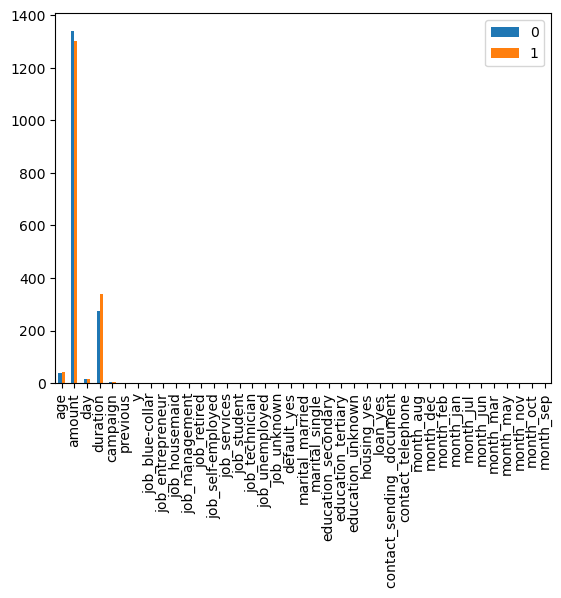

In [32]:
#本当はｙ＝０の中で、正確に予測された人と謝った予測をされた人でどういう傾向があるか分析

false=tmp.loc[(tmp['pred']==1)&(tmp['true']==0)].index
true=tmp.loc[(tmp['pred']==0)&(tmp['true']==0)].index
true_df=train_val2.loc[true]
false_df=train_val2.loc[false]
pd.concat([true_df.mean(numeric_only=True)["age":],false_df.mean(numeric_only=True)["age":]],axis=1).plot(kind="bar")
true

### 9-25

<Axes: >

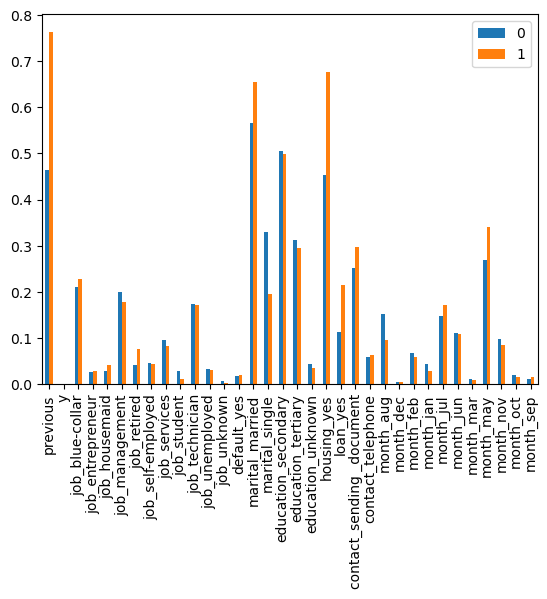

In [34]:
# code 9-25
#本当はｙ＝０の中で、正確に予測された人と誤った予測をされた人でどういう傾向があるか分析
 
false=tmp.loc[(tmp['pred']==1)&(tmp['true']==0)].index
true=tmp.loc[(tmp['pred']==0)&(tmp['true']==0)].index
true_df=train_val2.loc[true]
false_df=train_val2.loc[false]
dtf = pd.concat([true_df.mean(numeric_only=True)["age":],false_df.mean(numeric_only=True)["age":]],axis=1)
dtf["previous":].plot(kind="bar")
#true
#plt.savefig('chap09.png')

### 9-26値にばらつきが多いので標準化してグラフ化

<Axes: >

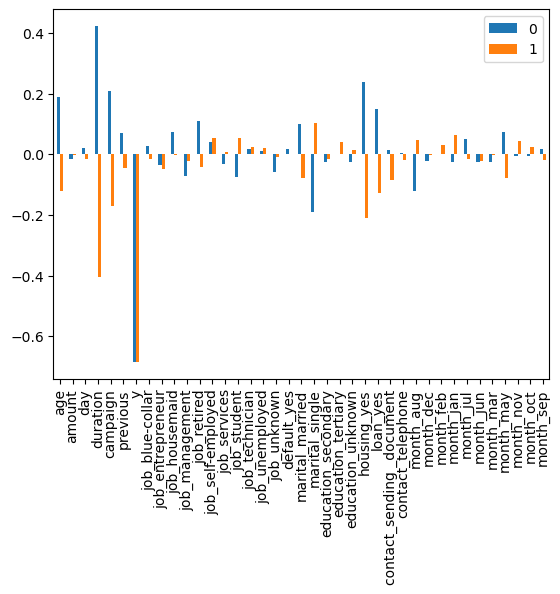

In [33]:
#値にばらつきが大きいので、標準化してもう一度グラフ化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
tmp2=train_val2.drop(str_col_name,axis=1)
sc_data = sc.fit_transform(tmp2)
sc_df = pd.DataFrame(sc_data,columns=tmp2.columns,index=tmp2.index)

true_df=sc_df.loc[true]
false_df=sc_df.loc[false]
true_df
temp2=pd.concat([false_df.mean(numeric_only=True)["age":],true_df.mean(numeric_only=True)["age":]],axis=1)
temp2.plot(kind="bar")

In [63]:
#青色の０は誤分類、オレンジ１は正解のデータ

# durationと housing_yesが大きく異なる
#実際はy=0の人で、 durationが大きい人は誤分類しやすい
#実際はy=0の人で、 housingが大きい人は誤分類しやすい


#事前に、durationが大きい人はy=1になりやすいということは分かっているので、「こういう人はy=0になりやすい」という
#特徴量を見つけ出して、特徴量×durationという特徴量を作って、durationに重み付けをする列を作れば正解率
#があがるのではないか？ 続きは3部に譲ってここでテストデータ評価を行う

### 9-27

In [35]:
model_tree=tree.DecisionTreeClassifier(max_depth=10,random_state=10,class_weight="balanced")
model_tree.fit(x,t)

test2=nan_fill(test)
t =test2['y']
x = test2.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
model_tree.score(x,t)

0.815333579063767

In [65]:
#テストデータの正解率は上昇した